# 0. Problem Description

Task #2:  Implement and compare various metrics to evaluate forecast performance (already calculated, test_task_data_2.csv). Please, present a comparison of metrics and their quick analysis. Could you propose some custom metrics? 

In [1]:
# Import useful libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting
%matplotlib inline

# <a name="1"></a> 1. Load and Review Data

In [2]:
# Import data, convert string dates to 'datetime64' and set the date column as index:
df = pd.read_csv('../input/test_task_data_2.csv', dayfirst=True,
                 parse_dates=['date'], infer_datetime_format=True,
                 index_col='date')

In [3]:
# Review the general info on data, paying attention to missing values and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1371 entries, 2013-01-02 to NaT
Data columns (total 2 columns):
Target price       1351 non-null float64
Target Forecast    1371 non-null float64
dtypes: float64(2)
memory usage: 32.1 KB


In [4]:
# Let's have a look at some examples
print(f'The first 5 examples')
print(df.head())
print(f'The last 5 examples')
print(df.tail())

The first 5 examples
            Target price  Target Forecast
date                                     
2013-01-02        112.47       111.120875
2013-01-03        112.14       110.988382
2013-01-04        111.31       111.142931
2013-01-07        111.40       110.161451
2013-01-08        111.94       110.278990
The last 5 examples
      Target price  Target Forecast
date                               
NaT            NaN        62.125227
NaT            NaN        63.845584
NaT            NaN        63.221835
NaT            NaN        63.291714
NaT            NaN        64.008737


In [5]:
# Drop rows with missing values:
df.dropna(inplace=True)
df.tail()

,Target price,Target Forecast
date,,
2018-03-21,69.47,59.986286
2018-03-22,68.91,59.559193
2018-03-23,70.45,60.230970
2018-03-26,69.47,61.794447
2018-03-27,69.66,61.836272


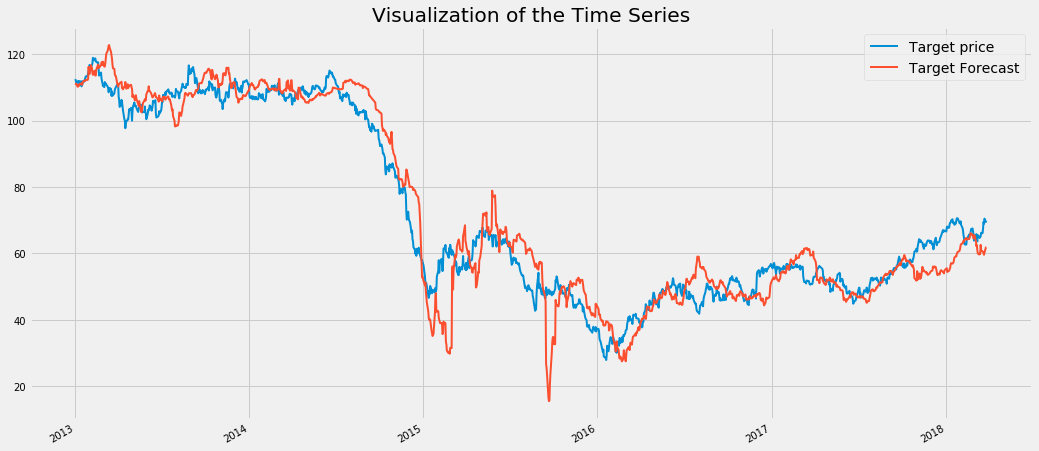

In [6]:
# Plot the time series
plt.style.use('fivethirtyeight')
ax = df.plot(subplots=False, layout=(1, 1),
             figsize=(16,8), fontsize=10, 
             linewidth=2, sharex=False,
             title='Visualization of the Time Series')
ax.set_xlabel('')
plt.show()

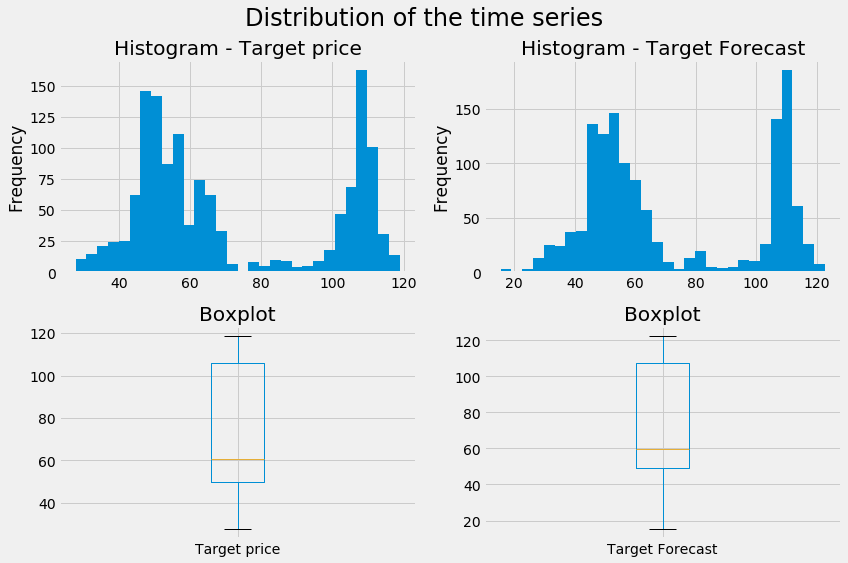

In [7]:
# Let's also plot distribiton of the time series:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,8),
                        sharex=False, sharey=False)
fig.suptitle(f'Distribution of the time series', fontsize=24)        
df['Target price'].plot.hist(bins=30, ax=axs[0,0])
axs[0,0].set_title('Histogram - Target price')
df['Target Forecast'].plot.hist(bins=30, ax=axs[0,1])
axs[0,1].set_title('Histogram - Target Forecast')
df[['Target price']].boxplot(ax=axs[1,0])
axs[1,0].set_title('Boxplot')
df[['Target Forecast']].boxplot(ax=axs[1,1])
axs[1,1].set_title('Boxplot')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [8]:
# And basic statistics
# Forecast has similar distribution to actual but larger variation in values
# As distributions are not normal, it is better to use the 5-number summary
df.describe()

,Target price,Target Forecast
count,1351.000000,1351.000000
mean,72.131199,72.357178
std,27.072883,28.607979
min,27.880000,15.482920
25%,49.705000,49.201905
50%,60.550000,59.451274
75%,105.850000,107.323141
max,118.900000,122.727987


In [9]:
# Let's also check the correlation of the time series
# Forecast and Actual have a high correlation coefficient (not surprising)
df.corr(method='pearson')

,Target price,Target Forecast
Target price,1.000000,0.969288
Target Forecast,0.969288,1.000000


# <a name="2"></a> 2. Evaluation of Time Series Forecasts
**Note:** I use efficient pandas/numpy methods below for fast vector operations on the whole time series

## Absolute Error Metrics

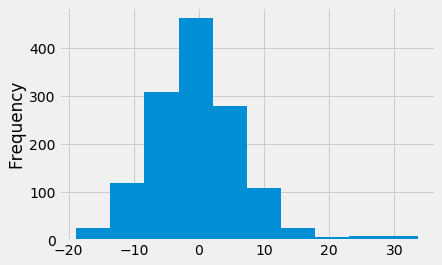

In [10]:
# Definition of deviation from actual/ forecast error/ residuals:
# A[t]-F[t], where A[t]=actual, F[t]=forecast at time t
forecast_error = df['Target price'].sub(df['Target Forecast'])
forecast_error.plot.hist()
plt.show()

In [11]:
# mean forecast error (ME) / forecast bias: sum(A[t]-F[t])/N
# we can see from the histogram that forecast bias is approx zero
me = forecast_error.mean()
print(f'ME (Forecast Bias) = {me:.2f}')

ME (Forecast Bias) = -0.23


In [12]:
# mean absolute error (MAE): sum(|A[t]-F[t]|)/N
mae = forecast_error.abs().mean()
print(f'MAE = {mae:.2f}')

MAE = 5.24


In [13]:
# mean squared error (MSE): sum((A[t]-F[t])^2)/N
mse = forecast_error.pow(2).mean()
print(f'MSE = {mse:.2f}')

MSE = 49.94


In [14]:
# root mean squared error (RMSE): sqrt(sum((A[t]-F[t])^2)/N)
rmse = forecast_error.pow(2).mean()**0.5
print(f'RMSE = {rmse:.2f}')

RMSE = 7.07


In [15]:
# root mean squared logarighmic error (RMSLE): sqrt(sum((log(1+A[t]) - log(1+F[t])^2))/N)
rmsle = (np.log(1+df['Target price'].copy()) - np.log(1+df['Target Forecast'].copy())).pow(2).mean()**0.5
print(f'RMSLE = {rmsle:.2f}')

RMSLE = 0.14


## Relative Error Metrics

In [16]:
# relative error: (A[t]-F[t])/A[t]
relative_error = forecast_error.div(df['Target price'])
relative_error.describe()

count    1351.000000
mean       -0.001958
std         0.124347
min        -0.417600
25%        -0.060203
50%        -0.004408
75%         0.050230
max         0.684537
dtype: float64

In [17]:
# mean percentage error (MPE): 100 * sum(relative_error)/N
mpe = 100 * relative_error.mean()
print(f'MPE = {mpe:.2f}%')

MPE = -0.20%


In [18]:
# mean absolute percentage error (MAPE): 100 * sum(|relative_error|)/N
# MAPE is used as a loss function for regression problems in ML
mape = 100 * relative_error.abs().mean()
print(f'MAPE = {mape:.2f}%')

MAPE = 8.56%


In [19]:
# R² score, the coefficient of determination: R2 = 1 - sum((A[t]-F[t])^2)/sum((A[t]-mean(A[t])^2)
# R2 formula can also be transformed into R2_alt = 1 - MSE/Variance(A)
r2 = 1 - forecast_error.pow(2).sum() / (df['Target price']-df['Target price'].mean()).pow(2).sum()
print(f'R2 = {r2:.3f}')
r2_alt = 1 - mse / df['Target price'].var(ddof=0)
print(f'R2_alt = {r2_alt:.3f}')

R2 = 0.932
R2_alt = 0.932


## Comparison of the regression forecast metrics

* __Mean forecast error__ measures bias of the forecasts. Our bias is close to zero, slightly negative. It means that the forecast consistently overestimate actuals for a little bit. While __Mean forecast error__ can indicate systematic bias, it is not useful as a measure of how 'good' the forecast is. It's because the overall __Mean forecast error__ could equal zero even with a set of forecasts that widely diverged from actual.
* Squaring error terms avoids the pitfall where positive and negative errors can cancel each other out. __MSE__ incorporates both the variance and the bias of the predictor. We have the case of effectively unbiased estimator, and __MSE__ is just the variance. However, the squaring operation makes the magnitude of __MSE__ (in our case = 50) not directly comparable to that of the original errors (in out case in the range [-20,+30]). 
* The two most popular metrics in the regression problems are __MAE__ and __RMSE__, which are of comparable magnitude to individual errors.
* __MAE__ is a linear score, which means that all individual differences are weighted equally in the average.
* __RMSE__ is the square root of __MSE__. In case of unbiased estimator, __RMSE__ is just the square root of variance, which is actually Standard Deviation. __RMSE__ penalizes the higher differences more than __MAE__. Generally, __RMSE__ will be higher or equal to __MAE__ (equal when all the differences are equal). In our case __RMSE__ is 7 and __MAE__ is 5.
* __What to use__: even being a more complex and biased towards higher deviation, __RMSE__ is the default metric of many models because loss function defined in terms of __RMSE__ is smoothly differentiable and makes it easier to perform math operations (important for the gradient descent). However, as a metric to compare between two models, __MAE__ is probably a better choice. Also, minimizing the squared error results in finding a mean and minimizing the absolute error results in finding a median. That's the reason why __MAE__ is more robust to outliers than __RMSE__.
* In case of __RMSLE__, we take the log of the forecasts and actual values. So basically, what changes is the variance we are measuring. __RMSLE__ penalizes an under-predicted forecast greater than an over-predicted. __RMSLE__ is usually used when we don't want to penalize huge differences in the forecast and the actual values when both predicted and true values are huge numbers. If both predicted and actual values are small: __RMSE__ and __RMSLE__ is same. If either predicted or the actual value is big: __RMSE__ > __RMSLE__. If both predicted and actual values are big: __RMSLE__ becomes almost negligible - in our case it's just 0.14.
* While the absolute error metrics are fine for comparing the effectiveness of different forecasting techniques when applied to the same time series, they are less useful when comparing effectiveness across multiple time-series, especially those of different magnitude. One way to make a metric that is useful for comparing forecasts on various-magnitude time series is to use __relative error__ as a substitute to __forecast error__ in metrics.
* The most common relative error metrics are __MPE__ and __MAPE__.  For the above forecast, __MPE__ = -0.2%, while __MAPE__ = 8.6%. As was the case for __ME__, __MPE__ is a metric for high or low bias, while __MAPE__ is useful as an overall accuracy.
* All of the relative error metrics suffer from the limitation that they can't be used on forecast data which have '0' values for any of the actuals, as this results in division-by-zero. Related to this is the problem of what happens when the actual value is merely very small compared to a forecast. These issues limit the effective use of these metrics for systems with widely varying actual values.
* __R2 score__, the coefficient of determination, is often used to explain how well the selected independent variable explains the variability in the dependent variable. The second term in the case of normally distributed residuals with zero mean (=our case) equals the fraction of unexplained variance, and the coeffitient itself equals the fraction of explained variance. The maximum value of __R2__ is 1, in our case __R2__ value is quite close to the maximum. It is easy to check that __R2 score__ equals the square of the Pearson correlation coefficient calculated above.